<a href="https://colab.research.google.com/github/mahmoud-ekhani/LLM_tutorials/blob/main/Fine_tuning_RoBERTa_Unhealthy_Comment_Corpus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#The plan for fine-tuning RoBERTa with the UCC

### 1. Set up
- Install transformers and pytorch lightning and import required packages.
- Loads UCC data and inspect it.

### 2. Create a dataset

- Load data into pytorch dataset

### 3. Build the model
 - Create a new pytorch (lightning) model with the Hugging Face RoBERTa model and a multi-label classification head.

### 4. Test model performance
- Test model performance using the ROC AUC and same test-set used in the original paper.

In [1]:
!nvidia-smi

Sun Feb  9 01:19:27 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.171.04             Driver Version: 535.171.04   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-PCIE-16GB           On  | 00000001:00:00.0 Off |                  Off |
| N/A   28C    P0              24W / 250W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Imports

In [2]:
%pip install torch --index-url https://download.pytorch.org/whl/cu121
%pip install transformers
%pip install pytorch-lightning
%pip install numpy
%pip install pandas
%pip install matplotlib
%pip install scikit-learn
%pip install tensorboard


Looking in indexes: https://download.pytorch.org/whl/cu121
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 35.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 99.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 97.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 78.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from transformers import (
    AutoModel, 
    AutoTokenizer,
    get_cosine_schedule_with_warmup
)
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
import torch.nn as nn
import torch.nn.functional as F
from sklearn import metrics
from typing import Optional, Dict, List

# Check versions and CUDA availability
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"GPU count: {torch.cuda.device_count()}")

PyTorch version: 2.5.1+cu121
CUDA available: True
GPU count: 4


In [4]:
train_path = 'data/ucc/train.csv'
val_path = 'data/ucc/val.csv'

In [5]:
train_data = pd.read_csv(train_path)

In [6]:
train_data.head(5)

,_unit_id,_trusted_judgments,comment,antagonize,antagonize:confidence,condescending,condescending:confidence,dismissive,dismissive:confidence,generalisation,generalisation:confidence,generalisation_unfair,generalisation_unfair:confidence,healthy,healthy:confidence,hostile,hostile:confidence,sarcastic,sarcastic:confidence
0,2319157561,4,"Three marriages, several bankrupt periods, inh...",0,1.0000,0,1.0000,0,1.0000,0,1.0000,0.0,1.0,1,0.7578,0,0.7565,0,1.0000
1,1739464982,4,The sense of entitlement among high school 'jo...,0,0.7634,0,0.7634,0,0.7634,0,1.0000,0.0,1.0,1,0.7634,0,0.7634,0,0.7634
2,1739457583,5,So what? He was just stating the obvious.,0,0.8121,0,0.5928,0,0.8043,0,1.0000,0.0,1.0,1,0.6163,0,1.0000,0,1.0000
3,2319156950,40,"If one is a Con, why yes, one would honk. Loud...",0,0.8508,0,0.8867,0,0.9239,0,0.8863,0.0,1.0,1,0.8508,0,0.9641,0,0.8868
4,2327196492,3,Ooohhh... It's Wendy Whiner... making sure to ...,0,1.0000,0,1.0000,0,1.0000,0,1.0000,0.0,1.0,1,1.0000,0,1.0000,0,1.0000


# inspect data

<Axes: >

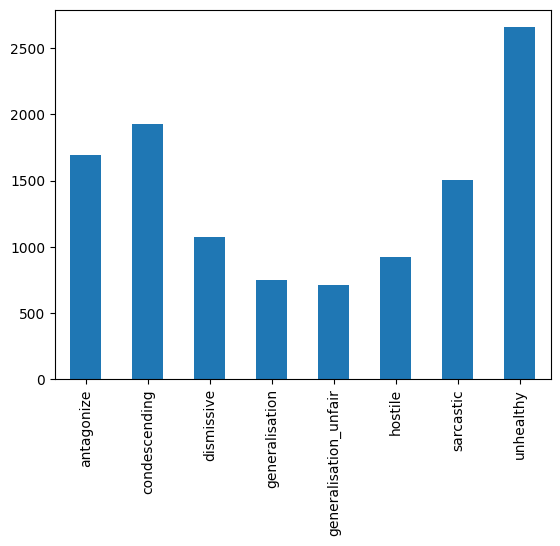

In [7]:
train_data['unhealthy'] = np.where(train_data['healthy'] == 1, 0, 1)

attributes = ['antagonize', 'condescending','dismissive','generalisation',
              'generalisation_unfair','hostile','sarcastic','unhealthy']

train_data[attributes].sum().plot.bar()

# Dataset

In [8]:
class UCCDataset(Dataset):
    """Dataset class for Unhealthy Comment Corpus (UCC)
    
    Args:
        data_path (str): Path to the CSV data file
        tokenizer: HuggingFace tokenizer
        attributes (List[str]): List of target attributes to predict
        max_token_len (int): Maximum token length for padding/truncation
        sample (Optional[int]): Number of samples to use (for balanced sampling)
    """
    def __init__(
        self, 
        data_path: str,
        tokenizer,
        attributes: List[str],
        max_token_len: int = 128,
        sample: Optional[int] = 5000
    ):
        self.tokenizer = tokenizer
        self.attributes = attributes
        self.max_token_len = max_token_len
        self.data = self._prepare_data(data_path, sample)

    def _prepare_data(self, data_path: str, sample: Optional[int]) -> pd.DataFrame:
        data = pd.read_csv(data_path)
        data['unhealthy'] = np.where(data['healthy'] == 1, 0, 1)
        
        # Convert all attribute columns to float type
        for attr in self.attributes:
            data[attr] = data[attr].astype(float)
            
        if sample:
            unhealthy = data[data[self.attributes].sum(axis=1) > 0]
            clean = data[data[self.attributes].sum(axis=1) == 0]
            return pd.concat([
                unhealthy,
                clean.sample(sample, random_state=42)
            ]).reset_index(drop=True)
        return data

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, index: int) -> Dict[str, torch.Tensor]:
        row = self.data.iloc[index]
        
        # Encode text
        encoding = self.tokenizer(
            str(row.comment),
            add_special_tokens=True,
            max_length=self.max_token_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        # Get labels and ensure they are float type
        labels = torch.tensor(
            self.data.iloc[index][self.attributes].values.astype(float),
            dtype=torch.float
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': labels
        }

In [9]:
model_name = 'roberta-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)
ucc_ds = UCCDataset(train_path, tokenizer, attributes=attributes, max_token_len=128)
ucc_ds_val = UCCDataset(val_path, tokenizer, attributes=attributes, max_token_len=128, sample=None)

In [10]:
ucc_ds.__getitem__(0)

{'input_ids': tensor([    0, 19897, 29846,     4,    38,    64,    75,   679, 46301,    74,
          9802,   132,     9,    39,   308,    95,     7,  1471,   559,   332,
             8,   146,  7064,   356,  1099,     4,   370,   214,   235,     6,
         46301,    16,    10, 34759,     4,     2,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,   

In [11]:
ucc_ds.__getitem__(0)['labels'].shape, ucc_ds.__getitem__(0)['input_ids'].shape, ucc_ds.__getitem__(0)['attention_mask'].shape

(torch.Size([8]), torch.Size([128]), torch.Size([128]))

In [12]:
len(ucc_ds)

9960

In [13]:
len(ucc_ds_val)

4427

# Data module

In [26]:
class UCCDataModule(pl.LightningDataModule):
    """PyTorch Lightning DataModule for UCC dataset
    
    Args:
        train_path (str): Path to training data
        val_path (str): Path to validation data
        attributes (List[str]): Target attributes to predict
        batch_size (int): Batch size for training
        max_token_length (int): Maximum token length
        model_name (str): HuggingFace model name
        num_workers (int): Number of workers for DataLoader
    """
    def __init__(
        self,
        train_path: str,
        val_path: str,
        attributes: List[str],
        batch_size: int = 32,
        max_token_length: int = 128,
        model_name: str = 'roberta-base',
        num_workers: int = 4
    ):
        super().__init__()
        self.train_path = train_path
        self.val_path = val_path
        self.attributes = attributes
        self.batch_size = batch_size
        self.max_token_length = max_token_length
        self.model_name = model_name
        self.num_workers = num_workers
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        
    def setup(self, stage: Optional[str] = None):
        if stage in (None, "fit"):
            self.train_dataset = UCCDataset(
                self.train_path,
                self.tokenizer,
                self.attributes
            )
            self.val_dataset = UCCDataset(
                self.val_path,
                self.tokenizer,
                self.attributes,
                sample=None
            )
            
    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=True,
            pin_memory=True
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
            pin_memory=True
        )

In [27]:
ucc_data_module = UCCDataModule(
    train_path=train_path,
    val_path=val_path, 
    attributes=attributes,
    batch_size=32,
    max_token_length=128,
    model_name='roberta-base',
    num_workers=4
)

In [28]:
ucc_data_module.setup()

In [29]:
ucc_data_module.train_dataloader()

In [30]:
# Number of batches (9960 // 16 = 623)
len(ucc_data_module.train_dataloader())

312

# Model

In [31]:
class UCCClassifier(pl.LightningModule):
    """Multi-label classifier for UCC using RoBERTa
    
    Args:
        config (Dict): Configuration dictionary containing model parameters
    """
    def __init__(self, config: Dict):
        super().__init__()
        self.save_hyperparameters(config)
        
        self.pretrained_model = AutoModel.from_pretrained(
            config['model_name'],
            return_dict=True
        )
        self.hidden = nn.Linear(
            self.pretrained_model.config.hidden_size,
            self.pretrained_model.config.hidden_size
        )
        self.classifier = nn.Linear(
            self.pretrained_model.config.hidden_size,
            config['n_labels']
        )
        self.dropout = nn.Dropout(p=0.1)
        self.loss_fn = nn.BCEWithLogitsLoss()

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.pretrained_model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        pooled_output = torch.mean(outputs.last_hidden_state, 1)
        
        hidden_output = self.dropout(F.relu(self.hidden(pooled_output)))
        logits = self.classifier(hidden_output)
        
        loss = None
        if labels is not None:
            loss = self.loss_fn(logits, labels)
            
        return loss, logits

    def training_step(self, batch):
        loss, _ = self(**batch)
        self.log("train_loss", loss, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch):
        loss, logits = self(**batch)
        self.log("val_loss", loss, prog_bar=True, logger=True)
        return {"val_loss": loss, "predictions": logits, "labels": batch["labels"]}

    def configure_optimizers(self):
        optimizer = AdamW(
            self.parameters(),
            lr=self.hparams.lr,
            weight_decay=self.hparams.weight_decay
        )
        
        scheduler = get_cosine_schedule_with_warmup(
            optimizer,
            num_warmup_steps=int(self.hparams.warmup * self.hparams.train_steps),
            num_training_steps=self.hparams.train_steps
        )
        
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "step"
            }
        }

## Training setup

In [44]:
# Set environment variable to avoid tokenizer warnings
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Configuration
config = {
    'model_name': 'distilroberta-base', 
    'n_labels': len(attributes),
    'batch_size': 32,
    'lr': 2e-5,
    'warmup': 0.1,
    'weight_decay': 0.01,
    'n_epochs': 10, 
    'train_steps': len(ucc_data_module.train_dataloader()) * 5  # total steps for 5 epochs
}

# Callbacks
checkpoint_callback = ModelCheckpoint(
    dirpath='checkpoints',
    filename='ucc-roberta-{epoch:02d}-{val_loss:.2f}',
    monitor='val_loss',
    mode='min',
    save_top_k=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=2,
    mode='min'
)

# Logger
logger = TensorBoardLogger("lightning_logs", name="ucc_classifier")

# Trainer 
trainer = pl.Trainer(
    max_epochs=config['n_epochs'],
    accelerator='gpu',
    devices=1,  # Use single GPU
    callbacks=[checkpoint_callback, early_stopping],
    logger=logger,
    gradient_clip_val=1.0,
    log_every_n_steps=10
)

# Model
model = UCCClassifier(config)

# Initialize the model's pooler weights from pretrained
model.pretrained_model.init_weights()

# Train
trainer.fit(model, ucc_data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/home/azureuser/mambaforge/envs/llm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /mnt/batch/tasks/shared/LS_root/mounts/clusters/mahmoud-4v100-compute/code/users/mebrahimkhani/LLM_tutorials/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name             | Type              | Params | Mode 
---------------------------------------------------------------
0 | pretrained_model | RobertaModel      | 82.1 M | eval 
1 | hidden           | Linear            | 590 K  | train
2 | classifier       | Linear            | 6.2 K  | train
3 | dropout          | Dropout           | 0      | train
4 | loss_fn          | BCEWithLogitsLoss | 0      | train
---------------------------------------------------------------
82.7 M    Trainable params
0         Non-trainable params
82.7 M    Total params
330.861   Total estimated model params size (MB)
4         Modules in train mode
120       Modules in eval mo

Epoch 4: 100%|██████████| 312/312 [00:45<00:00,  6.80it/s, v_num=5, train_loss=0.197, val_loss=0.177]


# Predict with model

In [43]:
def classify_raw_comments(model, dm):
    predictions = []
    model.eval() 
    for batch in dm.val_dataloader():
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        with torch.no_grad():
            _, logits = model(input_ids, attention_mask=attention_mask)  # Unpack loss and logits
            predictions.append(logits)
    flattened_predictions = torch.sigmoid(torch.cat(predictions, dim=0)).cpu().numpy()
    return flattened_predictions

In [45]:
predictions = classify_raw_comments(model, ucc_data_module)

In [41]:
val_data = pd.read_csv(val_path)
val_data['unhealthy'] = np.where(val_data['healthy'] == 1, 0, 1)
true_labels = np.array(val_data[attributes])

Text(0.5, 1.0, 'RoBERTa Trained on UCC Datatset - AUC ROC')

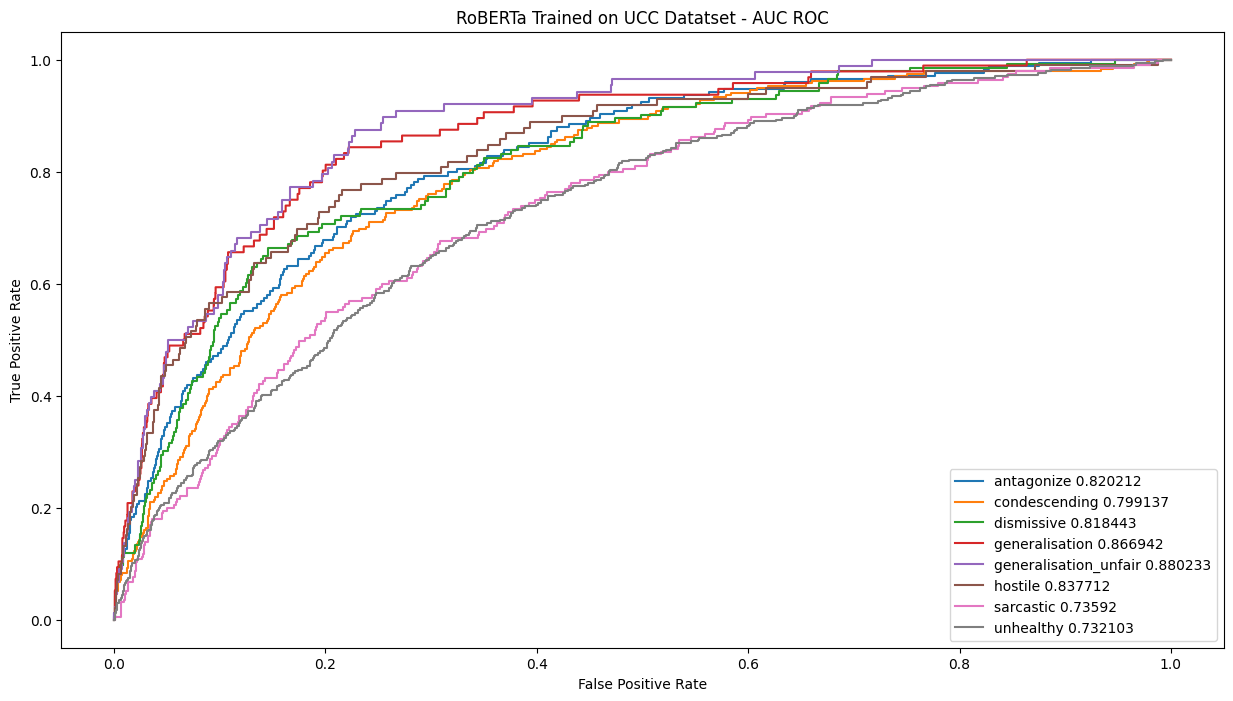

In [46]:
from sklearn import metrics
plt.figure(figsize=(15, 8))
for i, attribute in enumerate(attributes):
  fpr, tpr, _ = metrics.roc_curve(
      true_labels[:,i].astype(int), predictions[:, i])
  auc = metrics.roc_auc_score(
      true_labels[:,i].astype(int), predictions[:, i])
  plt.plot(fpr, tpr, label='%s %g' % (attribute, auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.title('RoBERTa Trained on UCC Datatset - AUC ROC')